<a href="https://colab.research.google.com/github/lko9911/ACK2025_Transparent_Object_Recognition/blob/main/Seg_%EB%AA%A8%EB%8D%B8(%ED%88%AC%EB%AA%85_%EB%AC%BC%EC%B2%B4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# 1. 라이브러리 임포트
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

# 2. 데이터셋 클래스 정의
class ClearGraspDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.image_files = sorted([
            f for f in os.listdir(image_dir)
            if f.endswith('.png') or f.endswith('.jpg')
        ])
        self.mask_files = sorted([
            f for f in os.listdir(mask_dir)
            if f.endswith('.png') or f.endswith('.jpg')
        ])

        if len(self.image_files) != len(self.mask_files):
            raise ValueError("이미지와 마스크 수가 다릅니다.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # 흑백 마스크 (0=배경, 255=투명물체)
        mask = (mask > 127).astype(np.uint8)  # 255 → 1 로 바꾸기

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()

# 3. 경로 설정
image_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/train/rgb-imgs"
mask_dir  = "/content/drive/MyDrive/Cleargrasp_Dataset/train/segmentation-masks"

# 4. 데이터 변환 정의
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# 5. 데이터셋 및 데이터로더 구성
dataset = ClearGraspDataset(image_dir, mask_dir, transform=transform)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False, num_workers=2)

# 6. 사전학습된 U-Net 모델 로딩
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
).cuda()

# 7. 손실함수 및 최적화 함수
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 8. 학습 루프
def train_model(n_epochs=10):
    best_val_loss = float('inf')
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            imgs, masks = imgs.cuda(), masks.cuda()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.cuda(), masks.cuda()
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_cleargrasp_unet.pth")
            print("✅ Best model saved")

# 9. 시각화 함수
def visualize_predictions():
    model.eval()
    imgs, masks = next(iter(val_loader))
    imgs, masks = imgs.cuda(), masks.cuda()
    preds = model(imgs)
    preds = torch.argmax(preds, dim=1)

    imgs = imgs.cpu().permute(0, 2, 3, 1).numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    for i in range(3):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(imgs[i])
        axs[0].set_title("Image")
        axs[1].imshow(masks[i], cmap='gray')
        axs[1].set_title("Ground Truth")
        axs[2].imshow(preds[i], cmap='gray')
        axs[2].set_title("Prediction")
        for ax in axs: ax.axis('off')
        plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

Epoch 1/2: 100%|██████████| 1137/1137 [5:04:29<00:00, 16.07s/it]


Epoch 1 | Train Loss: 0.0492 | Val Loss: 0.0200
✅ Best model saved


Epoch 2/2: 100%|██████████| 1137/1137 [10:39<00:00,  1.78it/s]


Epoch 2 | Train Loss: 0.0165 | Val Loss: 0.0149
✅ Best model saved


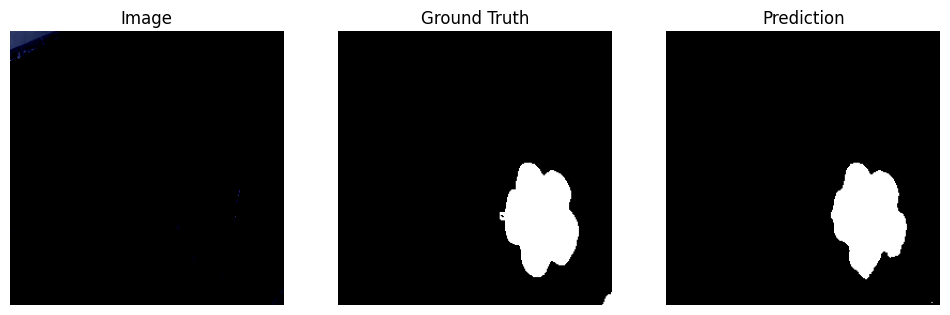

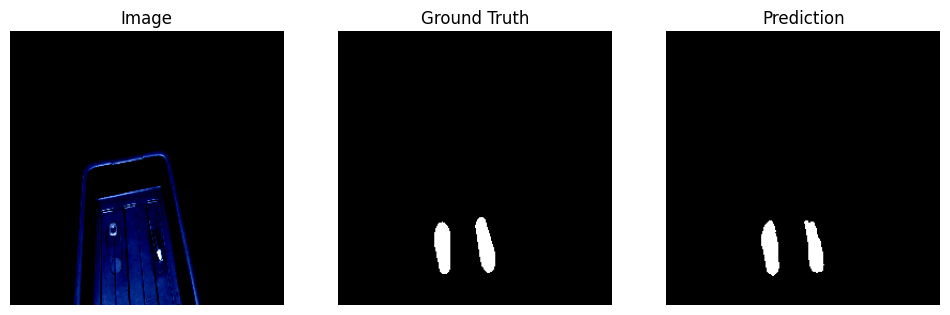

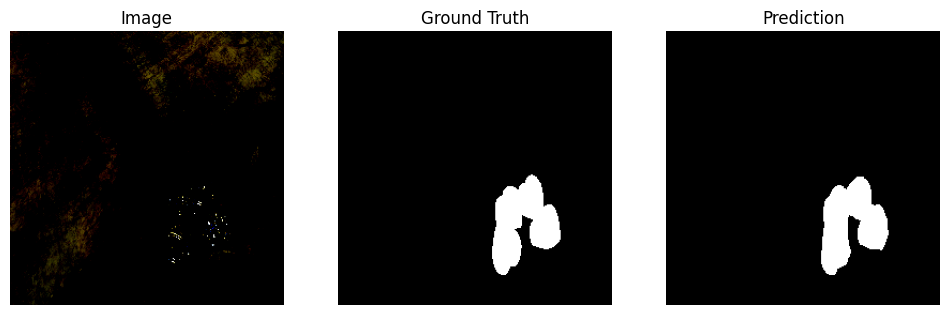

In [ ]:
# 10. 실행
if __name__ == '__main__':
    train_model(n_epochs=2)
    visualize_predictions()

In [6]:
# 테스트셋 경로 설정
test_image_dir = "/content/drive/MyDrive/Cleargrasp_Dataset/test/rgb-imgs"
test_mask_dir  = "/content/drive/MyDrive/Cleargrasp_Dataset/test/segmentation-masks"

# 테스트셋 정의
test_dataset = ClearGraspDataset(test_image_dir, test_mask_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# 학습된 best 모델 로드
model.load_state_dict(torch.load("best_cleargrasp_unet.pth"))
model.eval()

def calculate_pixel_accuracy(loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Testing"):
            imgs, masks = imgs.cuda(), masks.cuda()
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)  # (B, H, W)

            correct += (preds == masks).sum().item()
            total += torch.numel(masks)

    pixel_acc = correct / total
    print(f"🎯 Pixel Accuracy on Test Set: {pixel_acc * 100:.2f}%")
    return pixel_acc

calculate_pixel_accuracy(test_loader)


Testing: 100%|██████████| 17/17 [03:03<00:00, 10.79s/it]

🎯 Pixel Accuracy on Test Set: 97.97%


0.9797354787874131